# 509 Final Project

## Globally import libraries

In [1]:
from bs4 import BeautifulSoup
from collections import defaultdict, Counter
import datetime as dt
import emoji
import itertools
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymysql as mysql
import random
import re
import regex as rex
import requests
import shutil
from string import punctuation
import time
from tqdm import tqdm
import zipfile

import nltk
from nltk.corpus import stopwords
import spacy

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

import textacy.preprocessing as tprep

# Set pandas global options
pd.options.display.max_rows = 17

%matplotlib inline

## Upload data from CSV

In [2]:
'''Dir nav citation:
https://softhints.com/python-change-directory-parent/'''
curr_dir = os.path.abspath(os.curdir)
print(curr_dir)
os.chdir("..")
up1_dir = os.path.abspath(os.curdir)
print(up1_dir)

C:\Users\acarr\Documents\GitHub\ADS509_Final_project\deliverables
C:\Users\acarr\Documents\GitHub\ADS509_Final_project


In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = 'data'

file_in_name01 = 'master.csv'

file_in_path01 = os.path.join(up1_dir, data_location, file_in_name01)

print(f'CSV file 1 in path: {file_in_path01}')

CSV file 1 in path: C:\Users\acarr\Documents\GitHub\ADS509_Final_project\data\master.csv


### Review dataframe

In [4]:
slct_tbl_full_df01 = pd.read_csv(file_in_path01)
print(f'Dataframe shape: {slct_tbl_full_df01.shape}')
display(slct_tbl_full_df01.head())

Dataframe shape: (4509, 7)


source_name          author  \
0  The Washington Post             NaN   
1  The Washington Post  Amber Phillips   
2  The Washington Post    David Ovalle   
3  The Washington Post     Philip Bump   
4  The Washington Post             NaN   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4          The revolt of Christian home-schoolers...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/education/inter...  2023-05-30T18:25:37Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Deep Reads features The Washington Posts best ...   

                                        article_text  
0  Travelers in Alabama driving on Interstate 65 ...  
1  A federal prosecutor may be nearing a decision...  
2  A federal appeals court Tuesday cleared the wa...  
3  Speaking in Orlando in November 2015, Republic...  
4                                                NaN

## Exploratory Data Analysis (EDA)

### Count missing `article_text` feature

In [5]:
count_nan = slct_tbl_full_df01.isnull().sum()
 
# printing the number of values present
# in the column
print('Number of NaN values present: ' + str(count_nan))

Number of NaN values present: source_name        0
author            37
title              0
url                0
publish_date       0
content         3351
article_text       1
dtype: int64


### Count blank `article_text` feature

In [6]:
print(len(slct_tbl_full_df01[slct_tbl_full_df01['article_text']=='']))
display(slct_tbl_full_df01[slct_tbl_full_df01['article_text']==''].head(20))

0


Empty DataFrame
Columns: [source_name, author, title, url, publish_date, content, article_text]
Index: []

### Remove missing `article_text` rows

In [7]:
'''Drop missing citation:
https://pandas.pydata.org/pandas-docs/stable/reference
/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna'''
slct_tbl_full_df02 = slct_tbl_full_df01.dropna(subset=['article_text'])
print(f'Dataframe shape: {slct_tbl_full_df02.shape}')
display(slct_tbl_full_df02.head())

Dataframe shape: (4508, 7)


source_name          author  \
0  The Washington Post             NaN   
1  The Washington Post  Amber Phillips   
2  The Washington Post    David Ovalle   
3  The Washington Post     Philip Bump   
5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
5  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
5  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
5  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  
0  Travelers in Alabama driving on Interstate 65 ...  
1  A federal prosecutor may be nearing a decision...  
2  A federal appeals court Tuesday cleared the wa...  
3  Speaking in Orlando in November 2015, Republic...  
5  “Look, we know our country’s going in the wron...

In [8]:
tqdm.pandas(ncols=50)  # can use tqdm_gui, optional kwargs, etc
# Now you can use `progress_apply` instead of `apply`

# Raw text character and word counts
slct_tbl_full_df02['char_cnt'] = slct_tbl_full_df02['article_text'].progress_apply(len)
slct_tbl_full_df02['word_cnt'] = slct_tbl_full_df02['article_text'].progress_apply(lambda x: len(x.split()))
display(slct_tbl_full_df02.head())

100%|█████| 4508/4508 [00:00<00:00, 991917.03it/s]
C:\Users\acarr\AppData\Local\Temp\ipykernel_2724\1419634614.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slct_tbl_full_df02['char_cnt'] = slct_tbl_full_df02['article_text'].progress_apply(len)
100%|██████| 4508/4508 [00:00<00:00, 26263.92it/s]
C:\Users\acarr\AppData\Local\Temp\ipykernel_2724\1419634614.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slct_tbl_full_df02['word_cnt'] = slct_tbl_full_df02['article_text'].progress_apply(lambda x: len(x

source_name          author  \
0  The Washington Post             NaN   
1  The Washington Post  Amber Phillips   
2  The Washington Post    David Ovalle   
3  The Washington Post     Philip Bump   
5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
5  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
5  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
5  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  
0  Travelers in Alabama driving on Interstate 65 ...      5746       920  
1  A federal prosecutor may be nearing a decision...      6814      1089  
2  A federal appeals court Tuesday cleared the wa...      5479       869  
3  Speaking in Orlando in November 2015, Republic...      5907       955  
5  “Look, we know our country’s going in the wron...      4563       750

### Descriptive statistics

In [9]:
slct_tbl_full_df02[['source_name',
                    'author',
                    'publish_date',
                    'article_text']].describe(include="O").T

count unique                                                top  \
source_name   4508      4                                           Fox News   
author        4472    956                                   Associated Press   
publish_date  4508   4486                               2023-05-13T11:00:00Z   
article_text  4508   4508  Travelers in Alabama driving on Interstate 65 ...   

              freq  
source_name   2192  
author         450  
publish_date     3  
article_text     1

In [10]:
slct_tbl_full_df02.describe().T

count         mean          std    min     25%     50%     75%  \
char_cnt  4508.0  4655.501109  3137.364995  131.0  2832.0  3951.5  5664.5   
word_cnt  4508.0   731.031500   518.576508   16.0   432.0   607.0   889.0   

              max  
char_cnt  80585.0  
word_cnt  14322.0

In [11]:
slct_tbl_full_df02['source_name'].value_counts()

Fox News               2192
Breitbart News         1017
CNN                     773
The Washington Post     526
Name: source_name, dtype: int64

### Examine inclusion of "centrist" sources indicated by `author` feature

In [12]:
slct_tbl_full_df02a = slct_tbl_full_df02[slct_tbl_full_df02['author'].isin(['msn', 'Associated Press', 'Reuters'])]

display(slct_tbl_full_df02a[slct_tbl_full_df02a['author']=='msn'])

display(slct_tbl_full_df02a.groupby(by=['source_name', 'author']).count())

source_name author  \
17   The Washington Post    msn   
18   The Washington Post    msn   
22   The Washington Post    msn   
81   The Washington Post    msn   
84   The Washington Post    msn   
..                   ...    ...   
492  The Washington Post    msn   
502  The Washington Post    msn   
503  The Washington Post    msn   
506  The Washington Post    msn   
509  The Washington Post    msn   

                                                 title  \
17       State Dept seeks to expand space diplomacy...   
18                            SHOCK IN RUSSIAN CAPITAL   
22   Debate over whether AI will destroy us is divi...   
81   Corporate bankruptcies creeping up as pressure...   
84    The looming existential crisis for cable news...   
..                                                 ...   
492  Biden shows growing appetite to cross Putin's ...   
502  Behind-the-scenes videos of Tucker Carlson wer...   
503  Georgia probe of Trump broadens to activities ...   
506  DRAMA: Couple, both nurses, save man's life mi...   
509  'DRAG RACE' queen says cancellation of militar...   

                                                   url          publish_date  \
17   https://www.washingtonpost.com/technology/2023...  2023-05-30T17:00:04Z   
18   https://www.washingtonpost.com/world/2023/05/3...  2023-05-30T13:00:04Z   
22   https://www.washingtonpost.com/technology/2023...  2023-05-20T21:00:04Z   
81   https://www.washingtonpost.com/business/2023/0...  2023-05-23T12:00:04Z   
84   https://www.washingtonpost.com/media/2023/05/2...  2023-05-23T14:00:04Z   
..                                                 ...                   ...   
492  https://www.washingtonpost.com/national-securi...  2023-06-01T11:00:04Z   
502  https://www.washingtonpost.com/media/2023/06/0...  2023-06-02T02:00:03Z   
503  https://www.washingtonpost.com/nation/2023/06/...  2023-06-02T11:00:04Z   
506  https://www.washingtonpost.com/lifestyle/2023/...  2023-06-02T17:00:04Z   
509  https://www.washingtonpost.com/nation/2023/06/...  2023-06-02T11:00:04Z   

                                               content  \
17   State Department seeks to expand its space dip...   
18   KYIV, Ukraine A drone attack hit Moscow on Tue...   
22   The debate over whether AI will destroy us is ...   
81   Corporate bankruptcies are creeping up as pres...   
84   The looming existential crisis for cable news ...   
..                                                 ...   
492  President Bidens decision last month to help U...   
502  Behind-the-scenes videos of Tucker Carlson wer...   
503  Georgia probe of Trump broadens to activities ...   
506  Emily Raines and her boyfriend, Daniel Shiffle...   
509  ‘Drag Race’ queen says cancellation of militar...   

                                          article_text  char_cnt  word_cnt  
17   With tensions rising in space, low Earth orbit...      6249      1008  
18   KYIV, Ukraine — A drone attack hit Moscow on T...      8700      1395  
22   At a congressional hearing this week, OpenAI C...     11197      1818  
81   Corporate bankruptcies are edging back up afte...      5115       802  
84   After a week of promotion and controversy, CNN...      7136      1154  
..                                                 ...       ...       ...  
492  President Biden’s decision last month to help ...      9676      1533  
502  In the days after Tucker Carlson’s abrupt firi...      5724       912  
503  An Atlanta-area investigation of alleged elect...     14622      2359  
506  Emily Raines and her boyfriend, Daniel Shiffle...      5161       898  
509  This week, Martin Cooper, who performs as drag...      4190       712  

[25 rows x 9 columns]

title  url  publish_date  content  \
source_name         author                                                
CNN                 Reuters               6    6             6        1   
Fox News            Associated Press    450  450           450       73   
                    Reuters               1    1             1        0   
The Washington Post msn                  25   25            25       25   

                                      article_text  char_cnt  word_cnt  
source_name         author                                              
CNN                 Reuters                      6         6         6  
Fox News            Associated Press           450       450       450  
                    Reuters                      1         1         1  
The Washington Post msn                         25        25        25

In [13]:
counter = Counter(slct_tbl_full_df02['author'])

word_cutoff = 5
con_feature_words = set()

for word, count in counter.items():
    if count > word_cutoff:
        con_feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(con_feature_words)} words as features in the model.")
print(con_feature_words)

With a word cutoff of 5, we have 151 words as features in the model.
{nan, 'Madeline Coggins', 'Joshua Klein, Joshua Klein', 'Brian Fung', 'Aaron Blake', 'Brian Flood', 'Brianna Herlihy', 'Hannah Knowles', 'Jacob Bliss, Jacob Bliss', 'Audrey Conklin', 'Hannah Bleau, Hannah Bleau', 'Gabriel Hays', 'Jordan Dixon-Hamilton, Jordan Dixon-Hamilton', 'Dylan Gwinn, Dylan Gwinn', 'Brooke Singman', 'Bob Price, Bob Price', 'Paul Waldman', 'Nicole Goodkind', 'Joseph Wulfsohn', 'Alisha Ebrahimji', 'Hanna Panreck', 'Philip Bump', 'msn', 'Tierney Sneed', 'Michael Ruiz', 'Frances Martel, Frances Martel', 'Hannah Grossman', 'Brie Stimson', 'Kyle Morris', 'Kurt Zindulka, Kurt Zindulka', 'Jessica Chasmar', 'Glenn Kessler', 'Paul Kane', 'Anders Hagstrom', 'Kendall Tietz', 'Louis Casiano', 'Rebecca Rosenberg', 'Simon Kent, Simon Kent', 'Elaine Mallon, Elaine Mallon', 'Breitbart London, Breitbart London', 'Ryan Gaydos', 'Julia Musto', 'Angelica Stabile', 'Joshua Nelson', 'Melissa Rudy', 'Mariana Alfaro', 'B

In [14]:
slct_tbl_full_df03 = slct_tbl_full_df02[~slct_tbl_full_df02['author'].isin(['msn', 'Associated Press', 'Reuters'])]
slct_tbl_full_df03 = slct_tbl_full_df03.reset_index()
slct_tbl_full_df03['political_lean'] = 'right'
print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())
slct_tbl_full_df03.loc[(slct_tbl_full_df03['source_name'] == 'The Washington Post') | (slct_tbl_full_df03['source_name'] == 'CNN'), 'political_lean'] = 'left'

display(slct_tbl_full_df03.head())

display(slct_tbl_full_df03['political_lean'].value_counts())

(4026, 11)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean  
0          right  
1          right  
2          right  
3          right  
4          right

index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean  
0           left  
1           left  
2           left  
3           left  
4           left

right    2758
left     1268
Name: political_lean, dtype: int64

<Axes: title={'center': 'Class distribution'}>

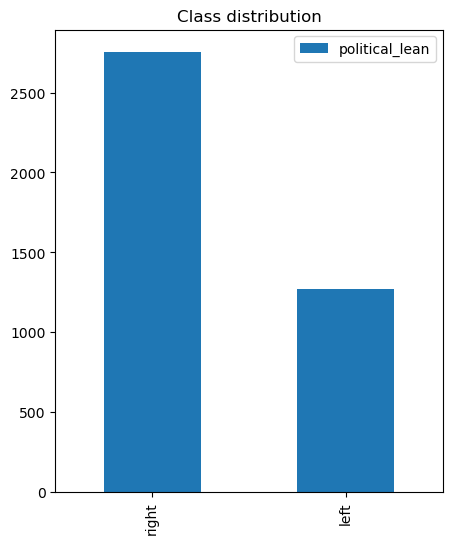

In [15]:
slct_tbl_full_df03['political_lean'].value_counts().plot(kind="bar",
                                                         legend=True,
                                                         figsize=(5,6),
                                                         title='Class distribution')

### Plot word counts

source_name
Breitbart News         Axes(0.125,0.11;0.775x0.77)
CNN                    Axes(0.125,0.11;0.775x0.77)
Fox News               Axes(0.125,0.11;0.775x0.77)
The Washington Post    Axes(0.125,0.11;0.775x0.77)
Name: word_cnt, dtype: object

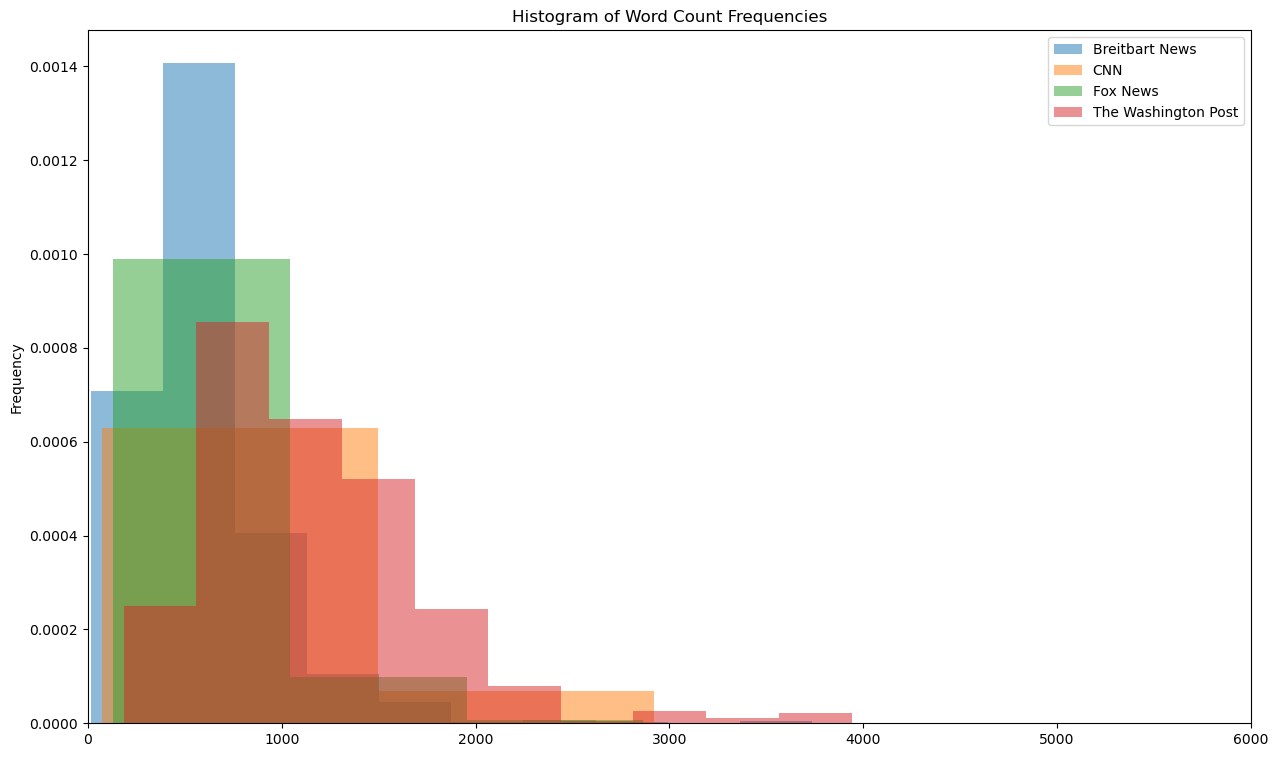

In [16]:
slct_tbl_full_df03.groupby('source_name')['word_cnt'].plot(kind="hist",
                                                           density=True,
                                                           alpha=0.5,
                                                           legend=True,
                                                           figsize=(15,9),
                                                           title='Histogram of Word Count Frequencies',
                                                           xlim=(0,6000))

## Data preprocessing

In [17]:
def uniq_tok(df_col=None):
    '''Display all unique tokens across all instances'''
    df_cols1 = pd.Series(df_col)

    all_tokens_lst01 = []

    [all_tokens_lst01.append(f) for f in df_cols1]
    all_tokens_lst01 = list(itertools.chain.from_iterable(all_tokens_lst01))
    all_tokens_set01 = set(all_tokens_lst01)
    print(len(sorted(all_tokens_set01)))
    print(sorted(all_tokens_set01))

In [18]:
slct_tbl_full_df04 = slct_tbl_full_df03.copy()

### Case-loading

In [19]:
slct_tbl_full_df03['lower'] = slct_tbl_full_df03['article_text'].apply(str.lower)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

(4026, 12)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  
0           left  travelers in alabama driving on interstate 65 ...  
1           left  a federal prosecutor may be nearing a decision...  
2           left  a federal appeals court tuesday cleared the wa...  
3           left  speaking in orlando in november 2015, republic...  
4           left  “look, we know our country’s going in the wron...

### Text normalization

#### Create function

In [20]:
def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

#### Call function

In [21]:
slct_tbl_full_df03['norm'] = slct_tbl_full_df03['lower'].apply(normalize)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,5):
    try:
        print(slct_tbl_full_df03['norm'][c], '\n')
    except:
        print(f'Skip {c}')

(4026, 13)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  
0  travelers in alabama driving on interstate 65 ...  
1  a federal prosecutor may be nearing a decision...  
2  a federal appeals court tuesday cleared the wa...  
3  speaking in orlando in november 2015, republic...  
4  "look, we know our country's going in the wron...

travelers in alabama driving on interstate 65 to parties and barbecues on memorial day might have seen messages on digital road signs honoring veterans who died fighting for the united states. but that's not what some drivers near clanton, ala., saw on monday. instead, motorists reported seeing a sign that was apparently hacked to display the words "reclaim america," a white nationalist slogan, and "patriot front us," referencing the white supremacist group that was involved in the deadly 2017 unite the right rally in charlottesville. "how does this come about?" wrote sarah hughes, a motorist who captured photos of the sign and posted them on twitter. "weird as hell."  a contractor's portable message board was hacked on i-65 in chilton county, ala., on monday afternoon, john mcwilliams, a spokesman for the alabama department of transportation (aldot) west central region, told the washington post in a statement. "a citizen alerted a nearby state trooper about the message, who then conta

### Remove special characters

#### Create function

In [22]:
rex_sep = rex.compile(r'&nbsp;')
rex_ucode = rex.compile(r'[\\]u20*')

'''re.sub lambda citation:
https://chat.openai.com/share/402ec66e-2802-4cda-af8c-6f9f5b097d85
'''
sep_lst = []
ucode_lst = []
# Add leading and trailing space to URLs
def rex_replace(text):
    #txt = str(text)
    #print(lambda x: x.replace('&nbsp;', ' '))
    #sep_lst.append(rex_sep.findall(txt))
    #ucode_lst.append(rex_ucode.findall(txt))
    text = text.replace(r'&nbsp;', ' ').replace(r'-', ' ')\
    .replace(r'\n', ' ').replace('\u2063', ' ').replace('\u2066', ' ')\
    .replace('\u2069', ' ').replace('\u200b', ' ').replace('\u200d', ' ')
    #txt = txt
    #text = text.replace(r'200b', 'd171c')
    #text = rex_ucode.sub('', text)
    return text

#### Call function

In [23]:
slct_tbl_full_df03['replace'] = slct_tbl_full_df03['norm'].apply(rex_replace)

#print(ucode_lst)
#print(sep_lst)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

(4026, 14)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  
0  travelers in alabama driving on interstate 65 ...  
1  a federal prosecutor may be nearing a decision...  
2  a federal appeals court tuesday cleared the wa...  
3  speaking in orlando in november 2015, republic...  
4  "look, we know our country's going in the wron...

'''Complex citation (add lambda):
https://chat.openai.com/share/a135754c-c38c-47ea-8f83-54d41d5397ab
'''
slct_tbl_full_df03['replace'] = slct_tbl_full_df03['norm'].apply(lambda x: x.replace('&nbsp;', ' ').replace(r'\n', ' ').replace('\u2063', ' ').replace('\u2066', ' ').replace('\u2069', ' ').replace('\u200b', ' ').replace('\u200d', ' '))

### RegEx find

#### Create function

In [24]:
rex_url_c = rex.compile(r'http[s]?:[\/]+[\S]*\s')

'''re.sub lambda citation:
https://chat.openai.com/share/402ec66e-2802-4cda-af8c-6f9f5b097d85
'''
# Add leading and trailing space to URLs
def rex_url(text):
    text = rex_url_c.sub(lambda match: ' ' + match.group(0) + ' ', text)
    return text

#### Call function

In [25]:
slct_tbl_full_df03['rex_urls'] = slct_tbl_full_df03['replace'].apply(rex_url)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

(4026, 15)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                            rex_urls  
0  travelers in alabama driving on interstate 65 ...  
1  a federal prosecutor may be nearing a decision...  
2  a federal appeals court tuesday cleared the wa...  
3  speaking in orlando in november 2015, republic...  
4  "look, we know our country's going in the wron...

### Split emojis

#### Create function

In [26]:
def emoji_split(text):
    return("".join([' ' + ch + ' ' if emoji.is_emoji(ch) else ch for ch in text]))

#### Call function

In [27]:
slct_tbl_full_df03['emoji_split'] = slct_tbl_full_df03['rex_urls'].apply(emoji_split)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,5):
    try:
        print(slct_tbl_full_df03['emoji_split'][c], '\n')
    except:
        print(f'Skip {c}')

(4026, 16)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                            rex_urls  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                         emoji_split  
0  travelers in alabama driving on interstate 65 ...  
1  a federal prosecutor may be nearing a decision...  
2  a federal appeals court tuesday cleared the wa...  
3  speaking in orlando in november 2015, republic...  
4  "look, we know our country's going in the wron...

travelers in alabama driving on interstate 65 to parties and barbecues on memorial day might have seen messages on digital road signs honoring veterans who died fighting for the united states. but that's not what some drivers near clanton, ala., saw on monday. instead, motorists reported seeing a sign that was apparently hacked to display the words "reclaim america," a white nationalist slogan, and "patriot front us," referencing the white supremacist group that was involved in the deadly 2017 unite the right rally in charlottesville. "how does this come about?" wrote sarah hughes, a motorist who captured photos of the sign and posted them on twitter. "weird as hell."  a contractor's portable message board was hacked on i 65 in chilton county, ala., on monday afternoon, john mcwilliams, a spokesman for the alabama department of transportation (aldot) west central region, told the washington post in a statement. "a citizen alerted a nearby state trooper about the message, who then conta

### Lemmatization using spaCY

In [28]:
nlp_trans = spacy.load('en_core_web_sm')

def lemma(text):
    trans_txt = nlp_trans(text)
    tokens = [t.lemma_ for t in trans_txt]
    return tokens

slct_tbl_full_df03['lemma'] = slct_tbl_full_df03['replace'].progress_apply(lemma)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,5):
    try:
        print(slct_tbl_full_df03['lemma'][c], '\n')
    except:
        print(f'Skip {c}')

#### Display globally unqiue tokens on lemmas

uniq_tok(df_col=slct_tbl_full_df03['lemma'])

### Split

#### Apply

In [29]:
slct_tbl_full_df03['split'] = slct_tbl_full_df03['emoji_split'].apply(str.split)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,5):
    try:
        print(slct_tbl_full_df03['split'][c], '\n')
    except:
        print(f'Skip {c}')

(4026, 17)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                            rex_urls  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                         emoji_split  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                               split  
0  [travelers, in, alabama, driving, on, intersta...  
1  [a, federal, prosecutor, may, be, nearing, a, ...  
2  [a, federal, appeals, court, tuesday, cleared,...  
3  [speaking, in, orlando, in, november, 2015,, r...  
4  ["look,, we, know, our, country's, going, in, ...

['travelers', 'in', 'alabama', 'driving', 'on', 'interstate', '65', 'to', 'parties', 'and', 'barbecues', 'on', 'memorial', 'day', 'might', 'have', 'seen', 'messages', 'on', 'digital', 'road', 'signs', 'honoring', 'veterans', 'who', 'died', 'fighting', 'for', 'the', 'united', 'states.', 'but', "that's", 'not', 'what', 'some', 'drivers', 'near', 'clanton,', 'ala.,', 'saw', 'on', 'monday.', 'instead,', 'motorists', 'reported', 'seeing', 'a', 'sign', 'that', 'was', 'apparently', 'hacked', 'to', 'display', 'the', 'words', '"reclaim', 'america,"', 'a', 'white', 'nationalist', 'slogan,', 'and', '"patriot', 'front', 'us,"', 'referencing', 'the', 'white', 'supremacist', 'group', 'that', 'was', 'involved', 'in', 'the', 'deadly', '2017', 'unite', 'the', 'right', 'rally', 'in', 'charlottesville.', '"how', 'does', 'this', 'come', 'about?"', 'wrote', 'sarah', 'hughes,', 'a', 'motorist', 'who', 'captured', 'photos', 'of', 'the', 'sign', 'and', 'posted', 'them', 'on', 'twitter.', '"weird', 'as', 'hell

#### Display globablly unqiue tokens on first split

In [30]:
uniq_tok(df_col=slct_tbl_full_df03['split'])

120484
['!', '!!', '!!!', '!!️', '!"', '!)', '!function(){"use', '"', '""i\'ve', '""while', '"#ad', '"#bamarush"', '"#boycottpetsmart."', '"#budlightpartner"', '"#budlightpartner."', '"#cannesyounot."', '"#desaster,"', '"#f', '"#justiceforjohncoughlin"', '"#metoo"', '"#thejohniknew."', '"#uncletimisanuncletom."', '"$1', '"$1.2', '"$2.9', '"$22', '"$3', '"$600', '"$8.41', '"\'a', '"\'agreed', '"\'ban\'', '"\'beyond', '"\'but', '"\'cannot', '"\'defund', '"\'did', '"\'durham', '"\'evidence', '"\'gender', '"\'health', '"\'heartbreaking\'', '"\'hey', '"\'high', '"\'home', '"\'i', '"\'i\'m', '"\'in', '"\'indirect', '"\'institution[s]', '"\'it\'s', '"\'justified\'', '"\'like,', '"\'mentally', '"\'open', '"\'protect', '"\'rob\'', '"\'rob,\'', '"\'survivors', '"\'the', '"\'there\'s', '"\'they\'re', '"\'til', '"\'tippy', '"\'top', '"\'upvoting\'', '"\'viewpoints\'', '"\'we', '"\'we\'re', '"\'what', '"\'what\'s', '"\'women', '"\'you', '"(a)s', '"(aderrien)', '"(ar', '"(h)er', '"(he', '"(he)', '"(

### Remove stop words

In [31]:
sw = stopwords.words("english")

# Add additional stop words
sw.extend(['',
           '️',
           'arent',
           'cannot',
           'cant',
           'couldnt',
           'couldve',
           'didnt',
           'doesnt',
           'dont',
           'hadnt',
           'hasnt',
           'havent',
           'hes',
           'im',
           "i'm",
           'isnt',
           'it’s',
           'ive',
           '𝚘𝚏',
           'mightnt',
           'mustnt',
           'neednt',
           'shant',
           'shes',
           'shouldnt',
           'shouldve',
           'thatll',
           'theyll',
           'theyve',
           'wasnt',
           'werent',
           'whats',
           'weve',
           'wont',
           'wouldnt',
           'wouldve',
           'yall',
           'youd',
           'youll',
           'youre',
           'youve',
           "we'll",
           "you’re",
           "you’ve",
           "you’ll",
           "you’d",
           "she’s",
           "it’s",
           "that’ll",
           "don’t",
           "should’ve",
           "aren’t",
           "couldn’t",
           "didn’t",
           "doesn’t",
           "hadn’t",
           "hasn’t",
           "haven’t",
           "isn’t",
           "mightn’t",
           "mustn’t",
           "needn’t",
           "shan’t",
           "shouldn’t",
           "wasn’t",
           "weren’t",
           "won’t",
           "wouldn’t",
           "i’m",
           "we’ll",
           'said',
           'told',
           'according',
           'fox',
           'news',
           'cnn',
           'breitbart',
           'reuters'])

print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

#### Create function

In [32]:
def sw_remover(tokens):
    return [t for t in tokens if t.lower() not in sw]

#### Call function

In [33]:
slct_tbl_full_df03['no_sw'] = slct_tbl_full_df03['split'].apply(sw_remover)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,2):
    print(slct_tbl_full_df03['no_sw'][c])

(4026, 18)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                            rex_urls  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                         emoji_split  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                               split  \
0  [travelers, in, alabama, driving, on, intersta...   
1  [a, federal, prosecutor, may, be, nearing, a, ...   
2  [a, federal, appeals, court, tuesday, cleared,...   
3  [speaking, in, orlando, in, november, 2015,, r...   
4  ["look,, we, know, our, country's, going, in, ... 

['travelers', 'alabama', 'driving', 'interstate', '65', 'parties', 'barbecues', 'memorial', 'day', 'might', 'seen', 'messages', 'digital', 'road', 'signs', 'honoring', 'veterans', 'died', 'fighting', 'united', 'states.', "that's", 'drivers', 'near', 'clanton,', 'ala.,', 'saw', 'monday.', 'instead,', 'motorists', 'reported', 'seeing', 'sign', 'apparently', 'hacked', 'display', 'words', '"reclaim', 'america,"', 'white', 'nationalist', 'slogan,', '"patriot', 'front', 'us,"', 'referencing', 'white', 'supremacist', 'group', 'involved', 'deadly', '2017', 'unite', 'right', 'rally', 'charlottesville.', '"how', 'come', 'about?"', 'wrote', 'sarah', 'hughes,', 'motorist', 'captured', 'photos', 'sign', 'posted', 'twitter.', '"weird', 'hell."', "contractor's", 'portable', 'message', 'board', 'hacked', '65', 'chilton', 'county,', 'ala.,', 'monday', 'afternoon,', 'john', 'mcwilliams,', 'spokesman', 'alabama', 'department', 'transportation', '(aldot)', 'west', 'central', 'region,', 'washington', 'post

#### Display no stop words

In [34]:
uniq_tok(df_col=slct_tbl_full_df03['no_sw'])

120307
['!', '!!', '!!!', '!!️', '!"', '!)', '!function(){"use', '"', '""i\'ve', '""while', '"#ad', '"#bamarush"', '"#boycottpetsmart."', '"#budlightpartner"', '"#budlightpartner."', '"#cannesyounot."', '"#desaster,"', '"#f', '"#justiceforjohncoughlin"', '"#metoo"', '"#thejohniknew."', '"#uncletimisanuncletom."', '"$1', '"$1.2', '"$2.9', '"$22', '"$3', '"$600', '"$8.41', '"\'a', '"\'agreed', '"\'ban\'', '"\'beyond', '"\'but', '"\'cannot', '"\'defund', '"\'did', '"\'durham', '"\'evidence', '"\'gender', '"\'health', '"\'heartbreaking\'', '"\'hey', '"\'high', '"\'home', '"\'i', '"\'i\'m', '"\'in', '"\'indirect', '"\'institution[s]', '"\'it\'s', '"\'justified\'', '"\'like,', '"\'mentally', '"\'open', '"\'protect', '"\'rob\'', '"\'rob,\'', '"\'survivors', '"\'the', '"\'there\'s', '"\'they\'re', '"\'til', '"\'tippy', '"\'top', '"\'upvoting\'', '"\'viewpoints\'', '"\'we', '"\'we\'re', '"\'what', '"\'what\'s', '"\'women', '"\'you', '"(a)s', '"(aderrien)', '"(ar', '"(h)er', '"(he', '"(he)', '"(

### Rejoin semi-processed tokens

In [35]:
slct_tbl_full_df03['no_sw_join'] = slct_tbl_full_df03['no_sw'].apply(" ".join)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,2):
    print(slct_tbl_full_df03['no_sw_join'][c])

(4026, 19)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                            rex_urls  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                         emoji_split  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                               split  \
0  [travelers, in, alabama, driving, on, intersta...   
1  [a, federal, prosecutor, may, be, nearing, a, ...   
2  [a, federal, appeals, court, tuesday, cleared,...   
3  [speaking, in, orlando, in, november, 2015,, r...   
4  ["look,, we, know, our, country's, going, in, ... 

travelers alabama driving interstate 65 parties barbecues memorial day might seen messages digital road signs honoring veterans died fighting united states. that's drivers near clanton, ala., saw monday. instead, motorists reported seeing sign apparently hacked display words "reclaim america," white nationalist slogan, "patriot front us," referencing white supremacist group involved deadly 2017 unite right rally charlottesville. "how come about?" wrote sarah hughes, motorist captured photos sign posted twitter. "weird hell." contractor's portable message board hacked 65 chilton county, ala., monday afternoon, john mcwilliams, spokesman alabama department transportation (aldot) west central region, washington post statement. "a citizen alerted nearby state trooper message, contacted aldot," mcwilliams tuesday. "aldot personnel immediately responded turned message board off. message boards 65 affected." mcwilliams added aldot investigating white supremacist language appeared sign near cl

### Remove punctuation

In [36]:
punctuation = set(punctuation) # speeds up comparison
print(punctuation)

# Add special hyphen mark
tw_punct = punctuation - {"#"}
print(tw_punct)
# Remove hash and at symbols for later capture of hashtag info
tw_punct = tw_punct - {"@"}
tw_punct = tw_punct - {"-"}
tw_punct = tw_punct - {"/"}
tw_punct.add("’")
tw_punct.add("‘")
tw_punct.add("”")
tw_punct.add("“")
tw_punct.add("…")
tw_punct.add("—")
tw_punct.add("...")
tw_punct.add("€")
tw_punct.add("±")
tw_punct.add("£")
tw_punct.add("¡")
tw_punct.add("§")
tw_punct.add("⦿")

print(tw_punct)

{'&', '+', '*', '\\', '{', '%', '"', '~', '?', '>', ')', "'", '}', '<', '#', '/', '$', '@', '^', '_', ',', '`', '.', ']', '[', '=', '-', '|', ';', '(', ':', '!'}
{'&', '+', '*', '\\', '{', '%', '"', '~', '?', '>', ')', "'", '}', '<', '/', '$', '@', '^', '_', ',', '`', '.', ']', '[', '=', '-', '|', ';', '(', ':', '!'}
{'\\', '+', '{', '%', '"', '~', "'", '<', '—', '_', '…', '`', '.', '“', ']', '[', '|', '’', ':', '!', '&', '*', '€', '?', '§', '>', ')', '”', '‘', '}', '¡', '$', '⦿', '^', '£', ',', '=', '...', '±', ';', '('}


#### Create function

In [37]:
def remove_punctuation(text, punct_set=tw_punct): 
    return("".join([ch for ch in text if ch not in punct_set]))

#### Call function

In [38]:
slct_tbl_full_df03['no_sw_join_no_punc'] = slct_tbl_full_df03['no_sw_join']\
.apply(remove_punctuation, punct_set=tw_punct)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,10):
    try:
        print(slct_tbl_full_df03['no_sw_join_no_punc'][c], '\n')
    except:
        print(f'\nerror on {c}\n')

(4026, 20)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                            rex_urls  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                         emoji_split  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                               split  \
0  [travelers, in, alabama, driving, on, intersta...   
1  [a, federal, prosecutor, may, be, nearing, a, ...   
2  [a, federal, appeals, court, tuesday, cleared,...   
3  [speaking, in, orlando, in, november, 2015,, r...   
4  ["look,, we, know, our, country's, going, in, ... 

travelers alabama driving interstate 65 parties barbecues memorial day might seen messages digital road signs honoring veterans died fighting united states thats drivers near clanton ala saw monday instead motorists reported seeing sign apparently hacked display words reclaim america white nationalist slogan patriot front us referencing white supremacist group involved deadly 2017 unite right rally charlottesville how come about wrote sarah hughes motorist captured photos sign posted twitter weird hell contractors portable message board hacked 65 chilton county ala monday afternoon john mcwilliams spokesman alabama department transportation aldot west central region washington post statement a citizen alerted nearby state trooper message contacted aldot mcwilliams tuesday aldot personnel immediately responded turned message board off message boards 65 affected mcwilliams added aldot investigating white supremacist language appeared sign near clanton 40 miles northwest montgomery ala of

### Tokenize

In [39]:
slct_tbl_full_df03['no_sw_join_no_punc_tok'] = slct_tbl_full_df03['no_sw_join_no_punc'].apply(str.split)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,2):
    print(slct_tbl_full_df03['no_sw_join_no_punc_tok'][c], '\n')

(4026, 21)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  ...  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920  ...   
1  A federal prosecutor may be nearing a decision...      6814      1089  ...   
2  A federal appeals court Tuesday cleared the wa...      5479       869  ...   
3  Speaking in Orlando in November 2015, Republic...      5907       955  ...   
4  “Look, we know our country’s going in the wron...      4563       750  ...   

                                               lower  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                            rex_urls  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                         emoji_split  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                               split  \
0  [travelers, in, alabama, driving, on, intersta...   
1  [a, federal, prosecutor, may, be, nearing, a, ...   
2  [a, federal, appeals, court, tuesday, cleared,...   
3  [speaking, in, orlando, in, november, 2015,, r...   
4  ["look,, we, know, our, country's, going, in, ...   

                                               no_sw  \


['travelers', 'alabama', 'driving', 'interstate', '65', 'parties', 'barbecues', 'memorial', 'day', 'might', 'seen', 'messages', 'digital', 'road', 'signs', 'honoring', 'veterans', 'died', 'fighting', 'united', 'states', 'thats', 'drivers', 'near', 'clanton', 'ala', 'saw', 'monday', 'instead', 'motorists', 'reported', 'seeing', 'sign', 'apparently', 'hacked', 'display', 'words', 'reclaim', 'america', 'white', 'nationalist', 'slogan', 'patriot', 'front', 'us', 'referencing', 'white', 'supremacist', 'group', 'involved', 'deadly', '2017', 'unite', 'right', 'rally', 'charlottesville', 'how', 'come', 'about', 'wrote', 'sarah', 'hughes', 'motorist', 'captured', 'photos', 'sign', 'posted', 'twitter', 'weird', 'hell', 'contractors', 'portable', 'message', 'board', 'hacked', '65', 'chilton', 'county', 'ala', 'monday', 'afternoon', 'john', 'mcwilliams', 'spokesman', 'alabama', 'department', 'transportation', 'aldot', 'west', 'central', 'region', 'washington', 'post', 'statement', 'a', 'citizen', 

#### Display globally unqiue tokens on final tokens

In [40]:
uniq_tok(df_col=slct_tbl_full_df03['no_sw_join_no_punc_tok'])

55772
['#1', '#10', '#11julio', '#14', '#1496', '#15', '#150', '#1576', '#181', '#19', '#2', '#2019ncov', '#2024election', '#22', '#227', '#25', '#30', '#35', '#42', '#49', '#4u', '#5', '#52', '#58', '#592', '#6', '#7', '#8', '#838', '#9', '#94', '#99', '#abajoladictadura', '#acnepositivity', '#ad', '#afghanevac', '#ai', '#aivoiceover', '#alpolitics', '#americandrag', '#andyvermautthanksyou', '#angeladavis', '#antifa', '#antisemitism', '#asia', '#auspol', '#avl', '#avlnews', '#azucenaalas10', '#babynames', '#bamarush', '#bansoffourbodies', '#baphomet', '#bch', '#beijing', '#bidenbordercrisis', '#bidenborderinvasion', '#bigguy', '#billsmafia', '#blackrock', '#bodyhairpositivity', '#bordercrisis', '#boycott', '#boycottkohls', '#boycottpetsmart', '#boycotttarget', '#breaking', '#breakingnews', '#budlightamendment', '#budlightpartner', '#bus', '#busdriver', '#caimanera', '#canciller', '#cannesyounot', '#carreramujer', '#ccpchina', '#cdnpoli', '#cena', '#chile', '#china', '#cibercuba', '#cl

### Pipeline consolidation

#### Pipeline function

In [41]:
def prepare(text, pipeline):
    '''Run a pipeline of text processing transformers'''
    tokens = str(text)
    
    # Pull key and val from trans dictionaries
    for transformer in pipeline:
        trans = list(transformer.keys())[0]
        args = list(transformer.values())[0]
        #print(trans)
        #print(args)
        if args == None:
            #print(1)
            tokens = trans(tokens)
        else:
            #print('check99', trans, args)
            tokens = trans(tokens, args) 

    return(tokens)

#### `article_text` preprocessing - w/o lemmatization

In [42]:
'''Set transformer pipeline 1:
Caseloading, normalization (using textacy), special ch removal,
split on whitespace, stop word removal, rejoin,
remove custom punctuation, tokenize
'''
transformers01 = [{str.lower: None},
                  {normalize: None},
                  {rex_replace: None},
                  {rex_url: None},
                  {emoji_split: None},
                  {str.split: None},
                  {sw_remover: None},
                  {" ".join: None},
                  {remove_punctuation: tw_punct},
                  {str.split: None},
                  {" ".join: None},
                 ]

# Apply transformers to pandas dataframe, w/ new col containing tokens
slct_tbl_full_df04['processed_text'] = slct_tbl_full_df04['article_text']\
.progress_apply(prepare, pipeline=transformers01)
slct_tbl_full_df04['num_tokens'] = slct_tbl_full_df04['processed_text'].map(len)

display(slct_tbl_full_df04.head())

# Review unique tokens across entire dataset
for c in range(0,5):
    try:
        print(slct_tbl_full_df04['processed_text'][c], '\n')
    except:
        print(f'Skip {c}')

100%|████████| 4026/4026 [00:19<00:00, 207.88it/s]


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                     processed_text  \
0           left  travelers alabama driving interstate 65 partie...   
1           left  federal prosecutor may nearing decision whethe...   
2           left  federal appeals court tuesday cleared way drug...   
3           left  speaking orlando november 2015 republican pres...   
4           left  look know countrys going wrong direction flori...   

   num_tokens  
0        4137  
1        4885  
2        4002  
3        4079  
4        3078

travelers alabama driving interstate 65 parties barbecues memorial day might seen messages digital road signs honoring veterans died fighting united states thats drivers near clanton ala saw monday instead motorists reported seeing sign apparently hacked display words reclaim america white nationalist slogan patriot front us referencing white supremacist group involved deadly 2017 unite right rally charlottesville how come about wrote sarah hughes motorist captured photos sign posted twitter weird hell contractors portable message board hacked 65 chilton county ala monday afternoon john mcwilliams spokesman alabama department transportation aldot west central region washington post statement a citizen alerted nearby state trooper message contacted aldot mcwilliams tuesday aldot personnel immediately responded turned message board off message boards 65 affected mcwilliams added aldot investigating white supremacist language appeared sign near clanton 40 miles northwest montgomery ala of

##### Display globally unqiue tokens on final tokens

In [43]:
slct_tbl_full_df04['processed_text_split'] = slct_tbl_full_df04['processed_text']\
.progress_apply(str.split)

uniq_tok(df_col=slct_tbl_full_df04['processed_text_split'])

100%|██████| 4026/4026 [00:00<00:00, 31857.64it/s]


55772
['#1', '#10', '#11julio', '#14', '#1496', '#15', '#150', '#1576', '#181', '#19', '#2', '#2019ncov', '#2024election', '#22', '#227', '#25', '#30', '#35', '#42', '#49', '#4u', '#5', '#52', '#58', '#592', '#6', '#7', '#8', '#838', '#9', '#94', '#99', '#abajoladictadura', '#acnepositivity', '#ad', '#afghanevac', '#ai', '#aivoiceover', '#alpolitics', '#americandrag', '#andyvermautthanksyou', '#angeladavis', '#antifa', '#antisemitism', '#asia', '#auspol', '#avl', '#avlnews', '#azucenaalas10', '#babynames', '#bamarush', '#bansoffourbodies', '#baphomet', '#bch', '#beijing', '#bidenbordercrisis', '#bidenborderinvasion', '#bigguy', '#billsmafia', '#blackrock', '#bodyhairpositivity', '#bordercrisis', '#boycott', '#boycottkohls', '#boycottpetsmart', '#boycotttarget', '#breaking', '#breakingnews', '#budlightamendment', '#budlightpartner', '#bus', '#busdriver', '#caimanera', '#canciller', '#cannesyounot', '#carreramujer', '#ccpchina', '#cdnpoli', '#cena', '#chile', '#china', '#cibercuba', '#cl

#### `article_text` preprocessing - w/ lemmatization

In [44]:
'''Set transformer pipeline 2:
Caseloading, normalization (using textacy), special ch removal,
lemmitization, stop word removal, rejoin,
remove custom punctuation, tokenize
'''
transformers02 = [{str.lower: None},
                  {normalize: None},
                  {rex_replace: None},
                  {lemma: None},
                  {" ".join: None},
                  {rex_url: None},
                  {emoji_split: None},
                  {str.split: None},
                  {sw_remover: None},
                  {" ".join: None},
                  {remove_punctuation: tw_punct},
                  {str.split: None},
                  {" ".join: None},
                 ]

# Apply transformers to pandas dataframe, w/ new col containing tokens
slct_tbl_full_df04['processed_lemmas'] = slct_tbl_full_df04['article_text']\
.progress_apply(prepare, pipeline=transformers02)
slct_tbl_full_df04['num_lemmas'] = slct_tbl_full_df04['processed_lemmas']\
.map(len)

display(slct_tbl_full_df04.head())

# Review unique tokens across entire dataset
for c in range(0,5):
    try:
        print(slct_tbl_full_df04['processed_lemmas'][c], '\n')
    except:
        print(f'Skip {c}')

100%|█████████| 4026/4026 [08:33<00:00,  7.83it/s]


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                     processed_text  \
0           left  travelers alabama driving interstate 65 partie...   
1           left  federal prosecutor may nearing decision whethe...   
2           left  federal appeals court tuesday cleared way drug...   
3           left  speaking orlando november 2015 republican pres...   
4           left  look know countrys going wrong direction flori...   

   num_tokens                               processed_text_split  \
0        4137  [travelers, alabama, driving, interstate, 65, ...   
1        4885  [federal, prosecutor, may, nearing, decision, ...   
2        4002  [federal, appeals, court, tuesday, cleared, wa...   
3        4079  [speaking, orlando, november, 2015, republican...   
4        3078  [look, know, countrys, going, wrong, direction...   

                                    processed_lemmas  num_lemmas  
0  traveler alabama drive interstate 65 party bar...        3895  
1  federal prosecutor may near decision whether c...        4564  
2  federal appeal court tuesday clear way drug ma...        3761  
3  speak orlando november 2015 republican preside...        3766  
4  look know country s go wrong direction say flo...        2857

traveler alabama drive interstate 65 party barbecue memorial day might see message digital road sign honor veteran die fight united states driver near clanton ala see monday instead motorist report see sign apparently hack display word reclaim america white nationalist slogan patriot front reference white supremacist group involve deadly 2017 unite right rally charlottesville come write sarah hughes motorist capture photo sign post twitter weird hell contractor s portable message board hack 65 chilton county ala monday afternoon john mcwilliam spokesman alabama department transportation aldot west central region tell washington post statement citizen alert nearby state trooper message contact aldot mcwilliam say tuesday aldot personnel immediately respond turn message board message board 65 affect mcwilliams add aldot investigate white supremacist language appear sign near clanton 40 mile northwest montgomery ala official give immediate indication responsible apparently hack interstate

##### Display globally unqiue tokens on final tokens

In [45]:
slct_tbl_full_df04['processed_lemmas_split'] = slct_tbl_full_df04['processed_lemmas']\
.progress_apply(str.split)

uniq_tok(df_col=slct_tbl_full_df04['processed_lemmas_split'])

100%|██████| 4026/4026 [00:00<00:00, 20715.59it/s]


43185
['#', '#charlotte', '/', '//', '/1', '/2', '/3', '/4', '/6', '/7', '/9', '/austin', '/e', '/getty', '/prnewswire/', '/r', '/tmx', '/yougov', '0', '00024', '001', '0018', '0036', '004', '0049', '005', '008', '01', '016', '02', '024', '025', '03', '035', '037', '04', '04/28', '0432', '05', '05/03', '05/09', '05/15', '05/22', '05/26', '050', '050322', '0523', '054', '055', '06', '063', '07', '079', '08', '09', '0900', '091', '092', '0adatadatawrapper', '0p', '0youngkin', '1', '1/', '1/1000th', '1/11', '1/2', '1/3', '1/4', '1/50th', '1/6', '10', '10/4/2020', '100', '1000', '10000', '100000', '1000000', '10000000', '100000000', '1000001', '100001', '1001', '1003', '1004', '10042', '1006', '10062', '10064', '10079', '100k', '100s', '100th', '100x', '101', '1010', '10103', '1011', '1013', '1015', '1019', '101st', '102', '1020', '102000', '1022', '1023', '10260', '10267', '10294', '102a', '103', '1030', '103000', '10338', '1038', '103a', '104', '1040', '104130', '1045', '104700', '1048',

### Calculate concentration ratio of each set of corpora

In [49]:
display(slct_tbl_full_df04['political_lean'].value_counts())

slct_tbl_full_df04_left = slct_tbl_full_df04[slct_tbl_full_df04['political_lean'] == 'left']

print(slct_tbl_full_df04_left.shape)
#display(slct_tbl_full_df04_left.head())

slct_tbl_full_df04_right = slct_tbl_full_df04[slct_tbl_full_df04['political_lean'] == 'right']

print(slct_tbl_full_df04_right.shape)
#display(slct_tbl_full_df04_right.head())

slct_tbl_full_df04_left_s1 = list(itertools.chain.from_iterable(
    list(pd.Series(slct_tbl_full_df04_left['processed_text_split']))))
print(slct_tbl_full_df04_left_s1[:10])
slct_tbl_full_df04_right_s1 = list(itertools.chain.from_iterable(
    list(pd.Series(slct_tbl_full_df04_right['processed_text_split']))))
print(slct_tbl_full_df04_right_s1[:10])

right    2758
left     1268
Name: political_lean, dtype: int64

(1268, 17)
(2758, 17)
['travelers', 'alabama', 'driving', 'interstate', '65', 'parties', 'barbecues', 'memorial', 'day', 'might']
['family', 'jennifer', 'farber', 'dulos', 'released', 'statement', 'wednesday', 'marking', 'four', 'years']


In [50]:
def concen_ratio(artist_lst=[],
                 lsts=[]):
    lyr_corp_lst = []
    for l in lsts:
        print(type(l))
        lyr_corp_lst.append(' '.join(l))
    print(len(lyr_corp_lst))
    #print(lyr_corp_lst)

    cv = CountVectorizer(input='content',
                         encoding='utf-8',
                         stop_words=None,
                         token_pattern=r'\S+'
                        )

    lyr_tokens_fit = cv.fit(lyr_corp_lst)

    print(pd.Series(cv.get_feature_names_out()).sample(15))

    lyr_tokens_sm = cv.transform(lyr_corp_lst)
    display(lyr_tokens_sm)

    df = pd.DataFrame(lyr_tokens_sm.toarray(),
                      columns=cv.get_feature_names_out())
    #display(df)

    df02 = df.copy()
    df02['r_sum'] = df02.sum(axis=1)
    #display(df02)

    '''Filter by frequency for all columns citation:
    OpenAI. (2021). ChatGPT [Computer software]. https://openai.com/;
    https://pandas.pydata.org/pandas-docs/stable/reference/api/
    pandas.DataFrame.ge.html'''
    condition = df.ge(5).all()
    #print(condition)

    # Get the list of columns that satisfy the condition
    columns = condition[condition].index.tolist()
    #print(columns)
    columns.append('r_sum')
    #print(columns)

    #display(df02[columns])

    df03 = df02[columns].copy()
    display(df03)

    '''Filter by frequency for all columns & add summary row citation:
    OpenAI. (2021). ChatGPT [Computer software]. https://openai.com/'''
    df04 = df03.apply(lambda x: x / df03.iloc[:,-1], axis=0)
    #display(df04)

    # Create new rows by dividing one artist row by the second artists row
    new_row01 = df04.iloc[0] / df04.iloc[1]
    new_row02 = df04.iloc[1] / df04.iloc[0]

    # Append the new row to the DataFrame
    df04 = df04.append(new_row01, ignore_index=True)
    df04 = df04.append(new_row02, ignore_index=True)
    display(df04)

    # Transpose dataframe
    df05 = df04.T
    df05 = df05.reset_index()
    df05.columns = ['token',
                    'c1_concen',
                    'c2_concen',
                    'c1c2_concen_ratio',
                    'c2c1_concen_ratio']
    #print(df05)
    
    '''Sort values citation:
    https://pandas.pydata.org/pandas-docs/stable/reference/api
    /pandas.DataFrame.sort_values.html'''
    print(artist_lst[0])
    display(df05[['token',
                  'c1c2_concen_ratio']].sort_values(by='c1c2_concen_ratio',
                                                    ascending=False).head(10))
    print(artist_lst[1])
    display(df05[['token',
                  'c2c1_concen_ratio']].sort_values(by='c2c1_concen_ratio',
                                                    ascending=False).head(10))

concen_ratio(artist_lst=['Left-Right Concentration Ratio',
                         'Right-Left Concentration Ratio'],
             lsts=[slct_tbl_full_df04_left_s1,
                   slct_tbl_full_df04_right_s1])

<class 'list'>
<class 'list'>
2
6074              atsum
41941       remediating
43253           roslynn
47503             steck
47441          stations
35392          oficials
52181    unsatisfactory
53007          vidsyich
6903               bars
48560             susan
20917      frayer/getty
51405             ucsfs
2991      @renncowboy69
48361            sunset
36109        outsmarted
dtype: object


<2x55772 sparse matrix of type '<class 'numpy.int64'>'
	with 79470 stored elements in Compressed Sparse Row format>

#2  #metoo   0  07    1   10  100  1000  10000  100000  ...  zero  zip  \
0   6      18  16   5  452  397  138    65     52      45  ...    67    6   
1   5       8  36   6  597  638  226    82    124      64  ...    97   11   

   zone  zones  zoo  zoom  zuckerberg     –   •    r_sum  
0    38      7   11    16          13  2390  53   756208  
1    38     11   40    17           7  1583  78  1062294  

[2 rows x 10960 columns]

C:\Users\acarr\AppData\Local\Temp\ipykernel_2724\3142308763.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df04 = df04.append(new_row01, ignore_index=True)
C:\Users\acarr\AppData\Local\Temp\ipykernel_2724\3142308763.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df04 = df04.append(new_row02, ignore_index=True)


#2    #metoo         0        07         1        10       100  \
0  0.000008  0.000024  0.000021  0.000007  0.000598  0.000525  0.000182   
1  0.000005  0.000008  0.000034  0.000006  0.000562  0.000601  0.000213   
2  1.685717  3.160720  0.624340  1.170637  1.063574  0.874124  0.857776   
3  0.593219  0.316384  1.601692  0.854236  0.940226  1.144002  1.165805   

       1000     10000    100000  ...      zero       zip      zone     zones  \
0  0.000086  0.000069  0.000060  ...  0.000089  0.000008  0.000050  0.000009   
1  0.000077  0.000117  0.000060  ...  0.000091  0.000010  0.000036  0.000010   
2  1.113533  0.589095  0.987725  ...  0.970301  0.766235  1.404764  0.893941   
3  0.898043  1.697520  1.012428  ...  1.030608  1.305083  0.711863  1.118642   

        zoo      zoom  zuckerberg         –         •  r_sum  
0  0.000015  0.000021    0.000017  0.003161  0.000070    1.0  
1  0.000038  0.000016    0.000007  0.001490  0.000073    1.0  
2  0.386310  1.322131    2.608848  2.120901  0.954519    1.0  
3  2.588593  0.756355    0.383311  0.471498  1.047648    1.0  

[4 rows x 10960 columns]

Left-Right Concentration Ratio


token  c1c2_concen_ratio
724      anonymity          17.559554
9886       thomass          16.295266
10776       willis          14.328596
6203         mehta          13.735473
3117        docket          13.204784
4351         ginni          12.361926
7423          pork          11.706369
10226  uncertainty          10.049468
4402       gorsuch           9.833350
9283        stamps           9.833350

Right-Left Concentration Ratio


token  c2c1_concen_ratio
1946        click          88.731653
2396    copyright          22.271149
6727          nyc          17.322004
8202  reparations          16.728785
2077   commenting          14.237264
756            ap          14.079072
766           app          13.089989
580        aliens          12.576250
1700          ccp          11.389811
5912       locker          10.962693

### 